In [1]:
import sys
import pyshark
import subprocess
from pcap2puml import puml
from pcap2puml import pcap
import urllib.request
from IPython.display import display, Image

Wrote PUML output to BobcallsAliceandtoomuchBW.pcap.puml
Wrote PNG output to BobcallsAliceandtoomuchBW.pcap.png
Displaying BobcallsAliceandtoomuchBW.pcap.png


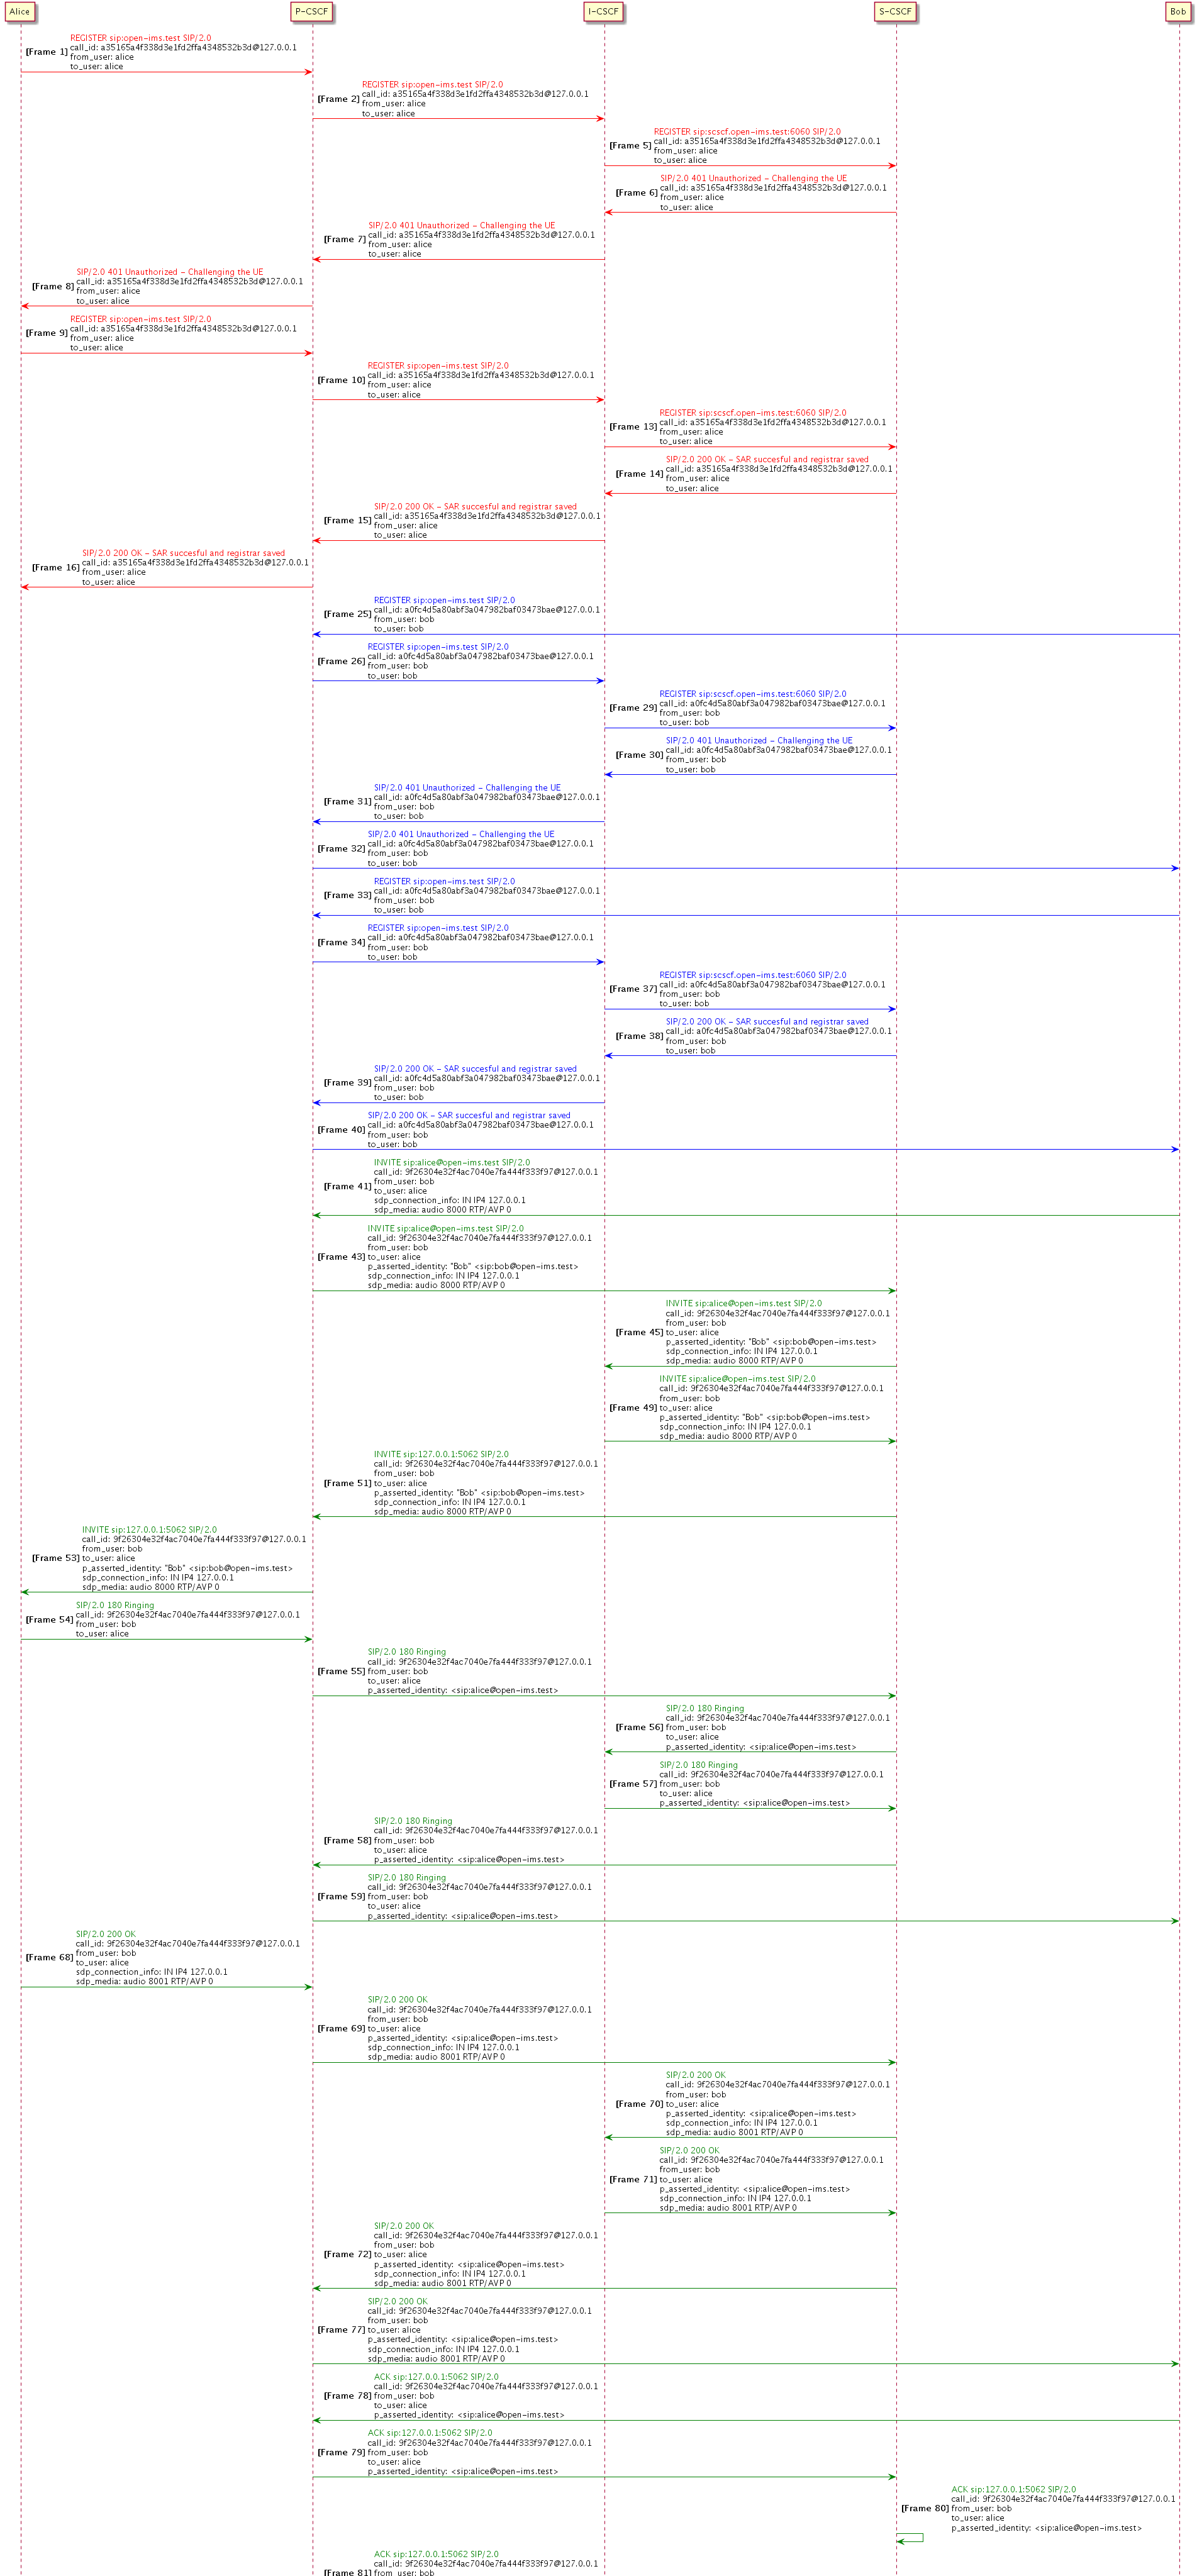

In [2]:
# Example using a PCAP file from http://mobilesociety.typepad.com/mobile_life/2008/10/an-ims-wireshark-trace.html
# Much of this code can be wrapped in an utility function (so we don't need to write it each time we create a new diagram),
# but this is just an example to illustrate how to use the modules in pcap2puml

# First we get the PCAP file
pcap_file_url = 'http://mobilesociety.typepad.com/mobile_life/files/BobcallsAliceandtoomuchBW.pcap'
local_file_path = 'BobcallsAliceandtoomuchBW.pcap'
(pcap_file_path, headers) = urllib.request.urlretrieve(pcap_file_url, local_file_path)

# We don't want the diagram to display all the packets, but just the ones filtered by the following filter
display_filter = '''
sip and (not sip.Status-Code == 100) 
and (not sip.CSeq.method == SUBSCRIBE) 
and (not sip.CSeq.method == NOTIFY)
'''

# The pcap.VoipTemplate class identifies the participants by IP only. For this example we want to identify them
# by both IP and port, so we create our custom template class, just inheriting from pcap.VoipTemplate butoverriding
# the get_participant_ids function
class VoipTemplate2(pcap.VoipTemplate):
    def get_participant_ids(self, packet):
        (srcip, dstip) = (packet.ip.src, packet.ip.dst)
        (srcport, dstport) = self.get_transport_ports(packet)
        return (srcip+':'+srcport, dstip+':'+dstport)

# However, we would like each participant to be displayed by a custom alias in the diagram
nodealiases = {'127.0.0.1:5062': 'Alice', 
               '127.0.0.1:4060': 'P-CSCF', 
               '127.0.0.1:5060': 'I-CSCF', 
               '127.0.0.1:6060': 'S-CSCF', 
               '127.0.0.1:5064': 'Bob'}

# So now we create our template
voip_template = VoipTemplate2(nodealiases=nodealiases)

# Now we load the PCAP packets
packets = pyshark.FileCapture(pcap_file_path, only_summaries=False, display_filter=display_filter)

# So we only need our template and the PCAP packets to create our SeqDiagram object
seq_diagram = voip_template.create_puml_seq_diagram(packets)
 
# Now we use this SeqDiagram object to output the PlantUML lines to a PlantUML file, and provided that we have plantuml.jar
# (you can get it from http://plantuml.com/download) we can also convert the PlantUML file to an image file (such as PNG file):
output_puml_file = pcap_file_path + '.puml'
output_png_file = pcap_file_path + '.png'
with open(output_puml_file, 'w') as puml_file:
    puml_file.write('\n'.join(seq_diagram.get_puml_lines()))
    command = 'java -jar $HOME/bin/plantuml.jar ' + output_puml_file
    print('Wrote PUML output to ' + output_puml_file)
    child = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    is_error = False
    for line in child.stderr:
        print(line)
        is_error = True
    if(not is_error):
        output_png_file = pcap_file_path + '.png'
        print('Wrote PNG output to ' + output_png_file)
        print('Displaying ' + output_png_file)
        display(Image(output_png_file, width=1024))